# Import dependencies and read-in CSVs

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [2]:
# Reads group dataset into main dataframe
df = pd.read_csv("Resources/Parkingtickets_Dec2016.csv", index_col=False)
df.head()

,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Violation Time,Violation County,From Hours In Effect,To Hours In Effect,Vehicle Color,Vehicle Year,Meter Number,Violation Post Code,Violation Description
0,GYG8911,NY,PAS,12/18/2016,24,SUBN,JEEP,1204P,Q,NaN,NaN,BK,2015,NaN,15 4,24-No Parking (exc auth veh)
1,8P82H,NY,OMT,12/21/2016,14,TAXI,NISSA,1015A,NY,ALL,ALL,YELLO,2014,-,NaN,NaN
2,GML6346,NY,PAS,12/19/2016,21,SDN,HONDA,1212P,K,1130A,0100A,GREY,2013,-,NaN,NaN
3,12203MG,NY,COM,12/1/2016,46,VAN,FRUEH,1137A,NY,ALL,ALL,BROWN,2015,-,NaN,NaN
4,HEG7444,NY,PAS,12/1/2016,36,4DSD,BMW,1027A,BK,NaN,NaN,BK,2016,NaN,NaN,PHTO SCHOOL ZN SPEED VIOLATION


In [3]:
# Reads US car auction dataframe for comparison to ticketed cars
auction_df = pd.read_csv("Resources/USA_cars_datasets.csv", index_col=False)
auction_df.head()

,Unnamed: 0,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


# Data Cleanup

In [4]:
# Removes DK (dark) and LT (light) demarkations for colors and drops any non-string values
for index, row in df.iterrows():
    try:
        if row["Vehicle Color"].startswith("D"):
            if row["Vehicle Color"].startswith("DK"):
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("DK")
            else:
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("D")
            
        elif row["Vehicle Color"].startswith("L"):
            if row["Vehicle Color"].startswith("LT"):
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("LT")
            else:
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("L")
        
    except AttributeError:
        df.drop(index, inplace=True)

In [5]:
# Defines standard color abbreviations as keys and irregular color abbreviations as values
colors_dict = {
    "black": ('BLA', 'BK'),
    "blue": ('BL', "NA"),
    "brown": ('BR', 'BN'),
    "silver": ("S", "CH", "CR"),
    "gray": ("GY", "GRA", "GREY", "GRY", "GEY"), # combines grays and silvers
    "green": ("GRE", "GN", "GRN"),
    "orange": "O",
    "red": ("R", "BRG", "BUR", "M"), # combines reds, burgundies, and maroons
    "tan": ("T", "BE", "BG", "BI", "GO", "GL"), # combines tans and beiges
    "white": "W",
    "yellow": "Y"
}

# Loops through keys
for color in colors_dict:
    # Changes varying colors in original df to standard colors
    df["Vehicle Color"].loc[df['Vehicle Color'].str.startswith(colors_dict[color], na=False)==True] = color
    
    # Changes varying colors in auction df to standard colors
    auction_df['color'].loc[auction_df['color'].str.contains(color, regex=False)==True] = color

C:\Users\Elliott\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# Creates violation color df and groups all colors outside top 11 as "Other"
color_df = df['Vehicle Color'].value_counts().rename_axis("Colors").reset_index(name='Num Cars')

other_total = 0

for i, r in color_df.iterrows():
    if r['Colors'] not in colors_dict.keys():
        other_total += r['Num Cars']
        color_df.drop(i, inplace=True)

other_df = pd.DataFrame({
    'Colors': ['other'],
    'Num Cars': other_total
})
color_df = pd.concat([color_df, other_df]).reset_index(drop=True)
color_df

,Colors,Num Cars
0,black,8423
1,white,7753
2,gray,7318
3,blue,2479
4,red,1611
5,brown,955
6,yellow,526
7,silver,449
8,tan,240
9,orange,182


In [7]:
# Creates auction df and groups all 
color_auction_df = auction_df['color'].value_counts().rename_axis("Colors").reset_index(name='Num Cars')

other_total = 0

for i, r in color_auction_df.iterrows():
    if r['Colors'] not in colors_dict.keys():
        other_total += r['Num Cars']
        color_auction_df.drop(i, inplace=True)
    

other_auction_df = pd.DataFrame({
    'Colors': ['other'],
    'Num Cars': other_total
})

color_auction_df = pd.concat([color_auction_df, other_auction_df]).reset_index(drop=True)
color_auction_df

,Colors,Num Cars
0,white,719
1,black,529
2,gray,395
3,silver,308
4,red,198
5,blue,157
6,green,24
7,orange,21
8,brown,15
9,yellow,12


# Plots

In [8]:
color_df['Expected'] = ''

# Add expected number of tickets based on auction data
for i, r in color_df.iterrows():
    color_df.loc[i, 'Expected'] = color_df['Num Cars'].sum()*(color_auction_df.loc[i, 'Num Cars']/
                                                              color_auction_df['Num Cars'].sum())

color_df

,Colors,Num Cars,Expected
0,black,8423,8753.16
1,white,7753,6440.08
2,gray,7318,4808.76
3,blue,2479,3749.61
4,red,1611,2410.47
5,brown,955,1911.33
6,yellow,526,292.178
7,silver,449,255.655
8,tan,240,182.611
9,orange,182,146.089


In [9]:
# Defines a function for plotting pie charts
def pie_plots(number, color):
    
    labels = ['%s, %1.1f %%' % (c, 100*n/number.sum()) for c, n in zip(color, number)]
    
    plt.pie(number,
        colors=[c if c!='other' else 'purple' for c in color],
        shadow=True,
        startangle=180,
        wedgeprops={'edgecolor':'k', 'linewidth': 0.5},
       )
    plt.legend(labels=labels,
          bbox_to_anchor=(1,.75))
    fig = plt.gcf()
    fig.set_size_inches(8,6)

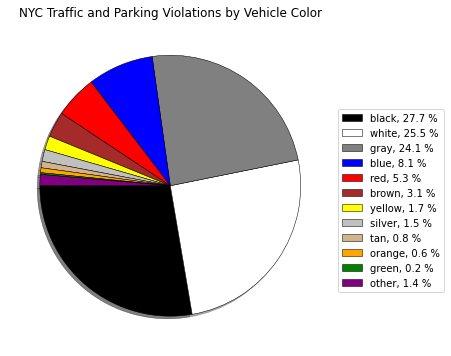

In [10]:
pie_plots(color_df['Num Cars'], color_df['Colors'])
plt.title('NYC Traffic and Parking Violations by Vehicle Color')
plt.savefig('Output/observed_tickets_by_color.png', dpi=100)
plt.show()

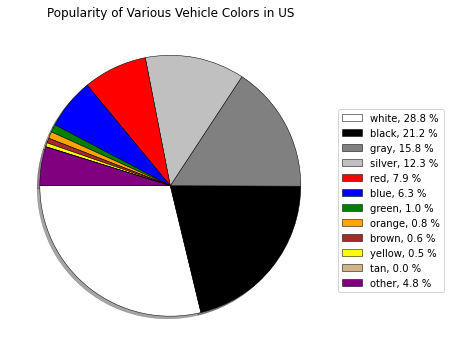

In [11]:
pie_plots(color_auction_df['Num Cars'], color_auction_df['Colors'])
plt.title('Popularity of Various Vehicle Colors in US')
plt.savefig('Output/predicted_tickets_by_color.png')
plt.show()

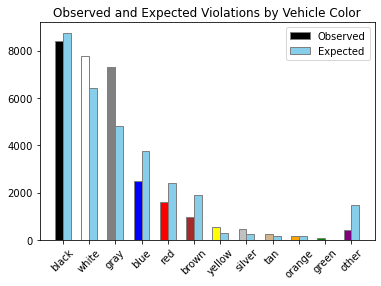

In [44]:
r1 = np.arange(len(color_df['Colors']))
r2 = [x + 0.3 for x in r1]


plt.bar(r1,color_df['Num Cars'], 
        width=0.3, label='Observed',
        color=[c if c!='other' else 'purple' for c in color_df['Colors']],
        edgecolor='gray'
       
       )
plt.bar(r2,color_df['Expected'], width=0.3, label='Expected', color='skyblue', edgecolor='gray')
plt.xticks([r + 0.15 for r in range(len(color_df['Colors']))], color_df['Colors'], rotation=45)
plt.legend()
plt.title('Observed and Expected Violations by Vehicle Color')
plt.savefig('Output/expected_observed_overlay.png')
plt.show()

# Analyses

In [13]:
critical_value = stats.chi2.ppf(q = 0.95, df = 11)
p_value = 0.05

if (stats.chisquare(color_df['Num Cars'], color_df['Expected'])[0] > critical_value)&(stats.chisquare(color_df['Num Cars'], color_df['Expected'])[1]<p_value):
    print('**There is a statistically significant difference between expected and observed violations per color.**')
    
else:
    print('There is no statistically significant difference between expected and observed violations per color.')


**There is a statistically significant difference between expected and observed violations per color.**
